In [6]:
import pandas as pd
import social_network_for_plays as sn
import warnings
from IPython.core.display import display, HTML

In [7]:
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [8]:
plays_df = sn.prepare_df_for_plays('data/plays.csv')
plays_df.head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Code
Dataline,,,,,,,,
4,Henry Iv,1,1.1.1,King Henry Iv,"So shaken as we are, so wan with care,",1,1,Henry Iv||||1.1.001||||King Henry Iv
5,Henry Iv,1,1.1.2,King Henry Iv,"Find we a time for frighted peace to pant,",1,1,Henry Iv||||1.1.001||||King Henry Iv
6,Henry Iv,1,1.1.3,King Henry Iv,And breathe short-winded accents of new broils,1,1,Henry Iv||||1.1.001||||King Henry Iv
7,Henry Iv,1,1.1.4,King Henry Iv,To be commenced in strands afar remote.,1,1,Henry Iv||||1.1.001||||King Henry Iv
8,Henry Iv,1,1.1.5,King Henry Iv,No more the thirsty entrance of this soil,1,1,Henry Iv||||1.1.001||||King Henry Iv


In [9]:
m = sn.prepare_df_by_encoding(plays_df)
m

,Code,PlayerLine,Play,Address,Act,Scene,Player,Relationship,Target
0,A Comedy Of Errors||||1.1.001||||Aegeon,"Proceed, Solinus, to procure my fall||||And by...",A Comedy Of Errors,1.1.001,1,1,Aegeon,NaN,NaN
1,A Comedy Of Errors||||1.1.002||||Duke Solinus,"Merchant of Syracuse, plead no more,||||I am n...",A Comedy Of Errors,1.1.002,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
2,A Comedy Of Errors||||1.1.003||||Aegeon,"Yet this my comfort: when your words are done,...",A Comedy Of Errors,1.1.003,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
3,A Comedy Of Errors||||1.1.004||||Duke Solinus,"Well, Syracusian, say in brief the cause||||Wh...",A Comedy Of Errors,1.1.004,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
4,A Comedy Of Errors||||1.1.005||||Aegeon,A heavier task could not have been imposed||||...,A Comedy Of Errors,1.1.005,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
5,A Comedy Of Errors||||1.1.006||||Duke Solinus,"Nay, forward, old man, do not break off so,|||...",A Comedy Of Errors,1.1.006,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
6,A Comedy Of Errors||||1.1.007||||Aegeon,"O, had the gods done so, I had not now||||Wort...",A Comedy Of Errors,1.1.007,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
7,A Comedy Of Errors||||1.1.008||||Duke Solinus,"And for the sake of them thou sorrowest for,||...",A Comedy Of Errors,1.1.008,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
8,A Comedy Of Errors||||1.1.009||||Aegeon,"My youngest boy, and yet my eldest care,||||At...",A Comedy Of Errors,1.1.009,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
9,A Comedy Of Errors||||1.1.010||||Duke Solinus,"Hapless AEgeon, whom the fates have mark'd||||...",A Comedy Of Errors,1.1.010,1,1,Duke Solinus,NaN,NaN


In [10]:
sn.extract_matrix(plays_df, 'Hamlet', m)

,Bernardo,Captain,Danes,First Ambassador,First Clown,First Player,First Priest,First Sailor,Francisco,Gentleman,Ghost,Guildenstern,Hamlet,Horatio,King Claudius,Laertes,Lord,Lord Polonius,Lucianus,Marcellus,Messenger,Ophelia,Osric,Player King,Player Queen,Prince Fortinbras,Queen Gertrude,Reynaldo,Rosencrantz,Second Clown,Servant,Voltimand
Bernardo,0,0,0,0,0,0,0,0,10,0,0,0,5,7,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
Captain,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Danes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Ambassador,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Clown,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0
First Player,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Priest,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Sailor,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Francisco,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
Gentleman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


------------------

In [11]:
print(sn.personality(plays_df, 'Hamlet', 'Hamlet'))
print(sn.personality(plays_df, 'Hamlet', 'Ophelia'))

5.46
6.43


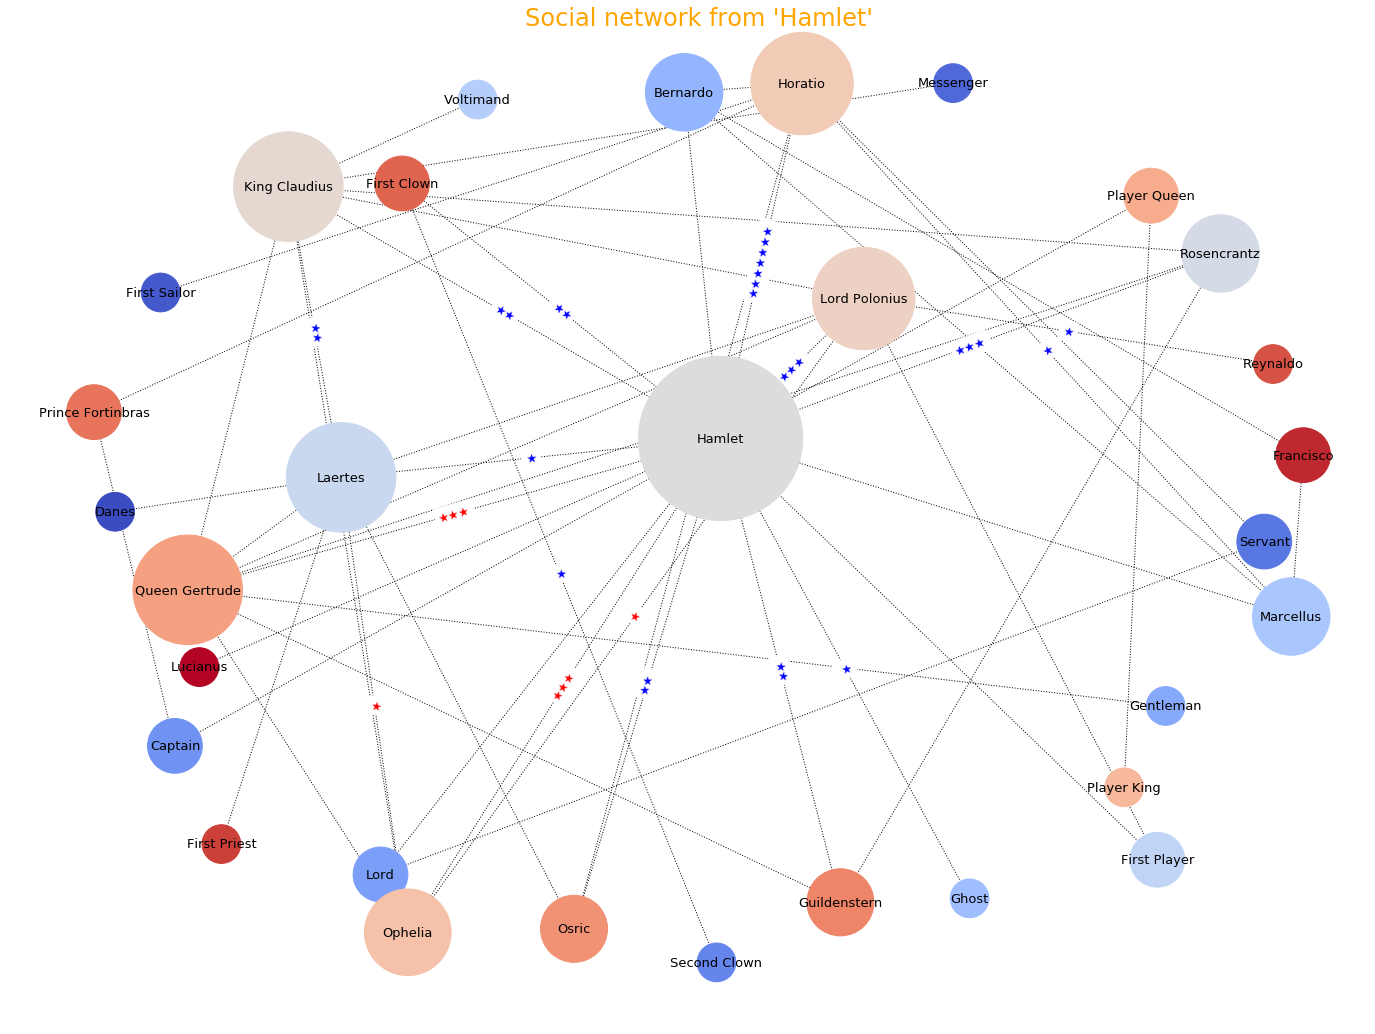

In [14]:
sn.plot_matrix(plays_df, 'Hamlet', m)

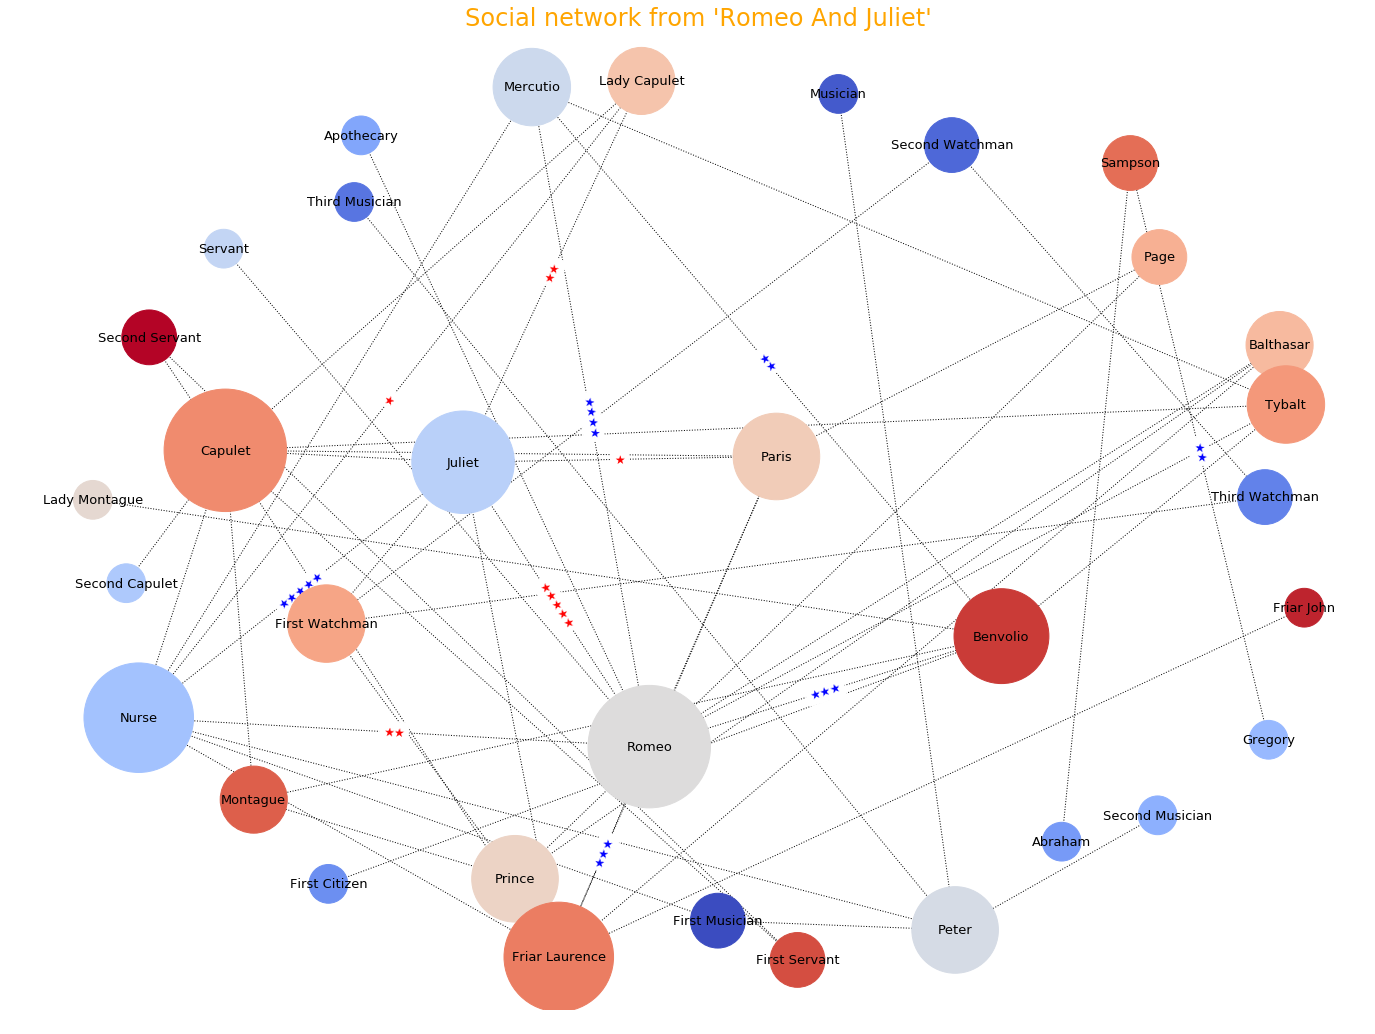

In [13]:
sn.plot_matrix(plays_df, 'Romeo And Juliet', m)